<a href="https://colab.research.google.com/github/Carterbouley/ElectricityPricePrediction/blob/master/multivariate_LSTM_electricity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

TensorFlow 2.x selected.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/open?id=1O0vmyRmcN0wT9FmIU7KkvFEK9FS36XdT'
link_id = link.split('=')[1]
download = drive.CreateFile({'id': link_id}) 
download.GetContentFile('re_fixed_multivariate_timeseries.csv')

In [ ]:
import pandas as pd
df = pd.read_csv('re_fixed_multivariate_timeseries.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

# df = df.sort_values(df['datetime'], ascending=[True])


df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime'], inplace = True)

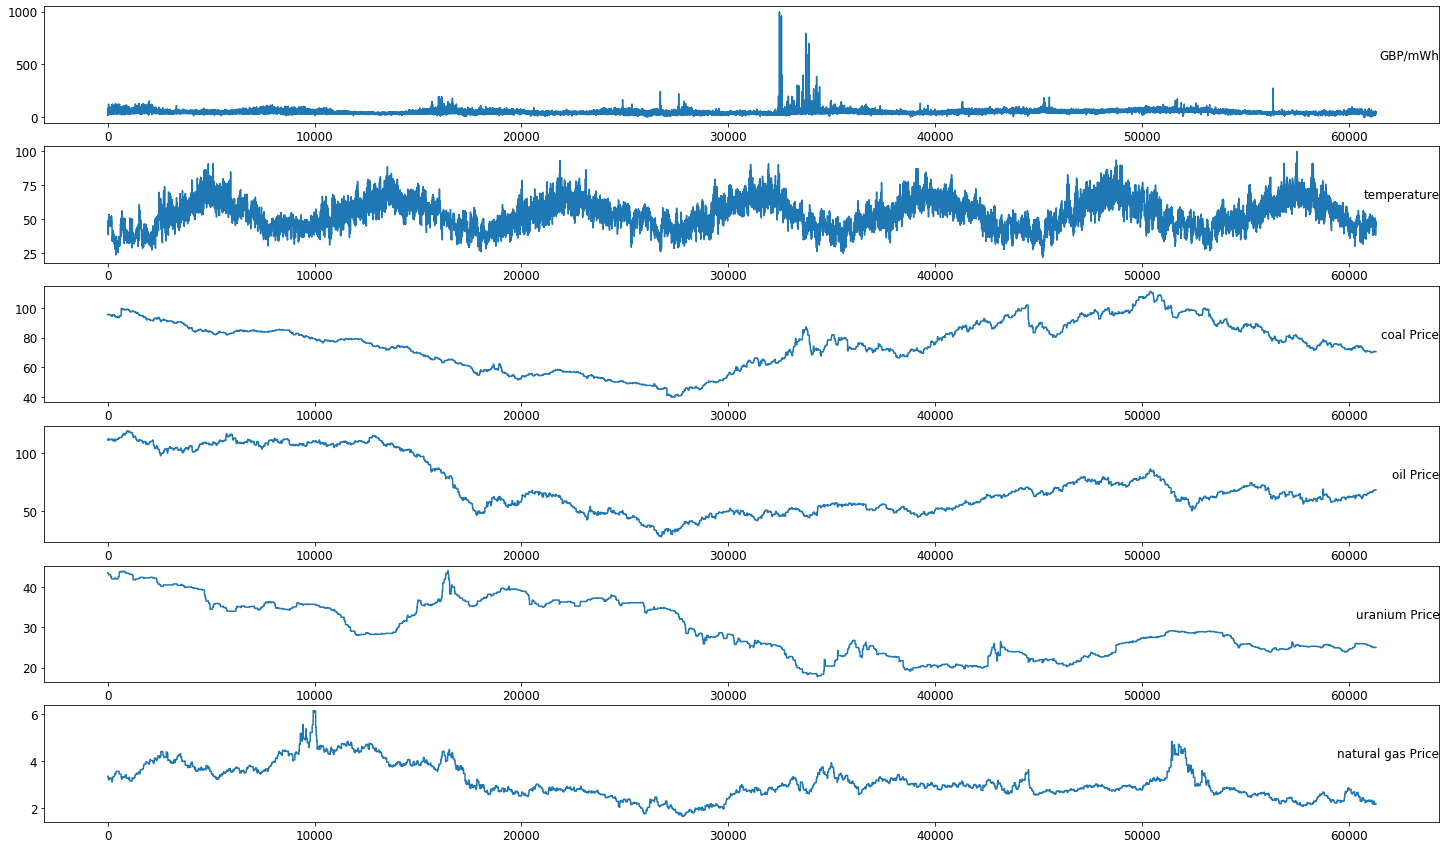

In [5]:
values = df.values

groups = [0, 1, 2, 3, 4, 5]
i = 1

# plot each column
plt.figure(figsize = (25, 15))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [ ]:
import seaborn as sns

### Our current shape is simply the shape of the dataframe : 61326 rows by 6 features

#### Because this is a time series analysis, we must make time a dimension. We want each window of time to include the past week of values, and look forward to the next 24 hours as this is what the model will do. For every row (or hour) we now have a window of 192 hours, and 6 features, giving us a shape (61134, 192, 6)

In [7]:
df.shape

(61326, 6)

In [ ]:
n_steps = 168


In [ ]:
n_steps = 168
data = df.values

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df)

data = scaled_df.values

In [ ]:
series_reshaped =  np.array([data[i:i + (n_steps+24)].copy() for i in range(len(data) - (n_steps+24))])

In [12]:
series_reshaped.shape

(61134, 192, 6)

### Now that we have our data in this format, we need to split it so we have blocks of 168 hours (1 week) of every feature for the input data, and for every 168 block of hours, we have a 24 hour output, so our model can 'see' the next 24 hours

In [ ]:
X_train = series_reshaped[:43800, :n_steps]
X_valid = series_reshaped[43800:52560, :n_steps]
X_test = series_reshaped[52560:, :n_steps]
Y = np.empty((61134, n_steps, 24))

for step_ahead in range(1, 24 + 1):
    Y[..., step_ahead - 1] = series_reshaped[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:43800]
Y_valid = Y[43800:52560]
Y_test = Y[52560:]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input):
        output, _ = self.lstm(input)
        output = self.fc(output[:, -1, :])
        return output

input_size = 6
hidden_size = 20
output_size = 24

model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MAPELoss()
optimizer = optim.Adam(model.parameters())

# Training loop
history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, Y_train)
    loss.backward()
    optimizer.step()
    history.append(loss.item())



# Validation loop
with torch.no_grad():
    output = model(X_valid)
    val_loss = criterion(output, Y_valid)


using PyTorch^

In [14]:
from keras import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping



Using TensorFlow backend.


In [ ]:
es = EarlyStopping(monitor = 'val_loss')

Deep Multivariate Recurrant Neural Network

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model6 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 6]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model6.compile(loss="mape", optimizer="adam")
history = model6.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 43800 samples, validate on 8760 samples
Epoch 1/20
43800/43800 [==============================] - 267s 6ms/sample - loss: 35.9477 - val_loss: 19.8042
Epoch 2/20
43800/43800 [==============================] - 261s 6ms/sample - loss: 18.0021 - val_loss: 18.4438
Epoch 3/20
43800/43800 [==============================] - 262s 6ms/sample - loss: 17.0743 - val_loss: 16.8844
Epoch 4/20
43800/43800 [==============================] - 266s 6ms/sample - loss: 16.3561 - val_loss: 17.4752
Epoch 5/20
43800/43800 [==============================] - 265s 6ms/sample - loss: 15.5954 - val_loss: 15.8778
Epoch 6/20
43800/43800 [==============================] - 263s 6ms/sample - loss: 14.6237 - val_loss: 14.6564
Epoch 7/20
43800/43800 [==============================] - 261s 6ms/sample - loss: 13.8062 - val_loss: 14.1265
Epoch 8/20
43800/43800 [==============================] - 259s 6ms/sample - loss: 13.3613 - val_loss: 13.2787
Epoch 9/20
43800/43800 [==============================] - 257s 6ms/samp

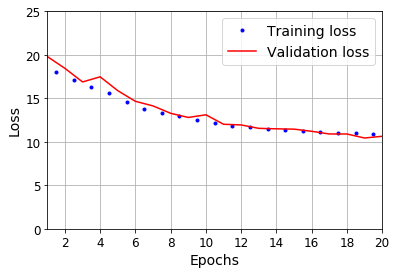

In [17]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 25])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
Y_pred = model6.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][23]))
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

In [19]:
# from google.colab import files
# actual.to_csv('RNNresults.csv') 
# files.download('RNNresults.csv')

KeyboardInterrupt: ignored

Simple Long-Short Term Memory Model

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model8 = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 6]),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model8.compile(loss="mape", optimizer="adam")
history = model8.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 43800 samples, validate on 8760 samples
Epoch 1/20
43800/43800 [==============================] - 17s 396us/sample - loss: 23.7422 - val_loss: 17.8767
Epoch 2/20
43800/43800 [==============================] - 12s 278us/sample - loss: 15.8340 - val_loss: 17.6940
Epoch 3/20
43800/43800 [==============================] - 12s 278us/sample - loss: 14.5503 - val_loss: 14.5041
Epoch 4/20
43800/43800 [==============================] - 12s 275us/sample - loss: 13.6600 - val_loss: 12.8433
Epoch 5/20
43800/43800 [==============================] - 12s 282us/sample - loss: 12.7653 - val_loss: 12.5096
Epoch 6/20
43800/43800 [==============================] - 12s 280us/sample - loss: 12.5216 - val_loss: 12.3429
Epoch 7/20
43800/43800 [==============================] - 12s 278us/sample - loss: 12.3605 - val_loss: 12.1632
Epoch 8/20
43800/43800 [==============================] - 12s 277us/sample - loss: 12.0969 - val_loss: 12.1775
Epoch 9/20
43800/43800 [==============================] - 12s 2

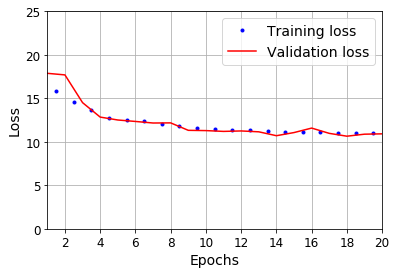

In [21]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
Y_pred = model8.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][23]))
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

# from google.colab import files
# actual.to_csv('simplelstmresults.csv') 
# files.download('simplelstmresults.csv')

Deep LSTM model

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

model9 = keras.models.Sequential([
    keras.layers.LSTM(80, return_sequences= True, input_shape=(168,6)),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(40, return_sequences= True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(30, return_sequences= True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model9.compile(loss="mape", optimizer="adam")
history9 = model9.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid), callbacks = [es] )

Train on 43800 samples, validate on 8760 samples
Epoch 1/20
43800/43800 [==============================] - 33s 756us/sample - loss: 16.5568 - val_loss: 14.9663
Epoch 2/20
43800/43800 [==============================] - 30s 693us/sample - loss: 12.6913 - val_loss: 11.9877
Epoch 3/20
43800/43800 [==============================] - 30s 693us/sample - loss: 11.6552 - val_loss: 10.9733
Epoch 4/20
43800/43800 [==============================] - 30s 692us/sample - loss: 11.1535 - val_loss: 11.0863


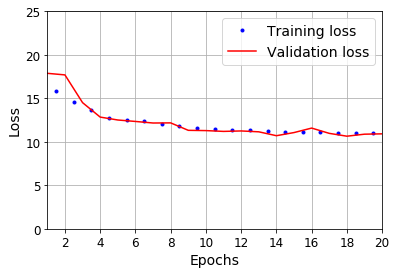

In [24]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
Y_pred = model9.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][23]))
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

# from google.colab import files
# actual.to_csv('deeplstmresults.csv') 
# files.download('deeplstmresults.csv')

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

model10 = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 6]),
    keras.layers.GRU(60, return_sequences=True),
    keras.layers.GRU(40, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model10.compile(loss="mape", optimizer="adam")
history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]), callbacks = [es])

Train on 43800 samples, validate on 8760 samples
Epoch 1/20
43800/43800 [==============================] - 16s 357us/sample - loss: 17.2059 - val_loss: 14.7603
Epoch 2/20
43800/43800 [==============================] - 13s 306us/sample - loss: 12.4322 - val_loss: 10.9715
Epoch 3/20
43800/43800 [==============================] - 13s 304us/sample - loss: 11.3294 - val_loss: 11.1987


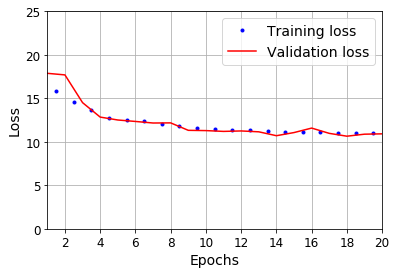

In [27]:

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
Y_pred = model10.predict(X_test)


In [ ]:
Y_pred.shape

In [ ]:
Y_pred = model10.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][3::2][0][23]))
    

actual = pd.DataFrame(X_test[: , 0, 0])
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

# from google.colab import files
# actual.to_csv('convlayerresults.csv') 
# files.download('convlayerresults.csv')